# Evaluating Robustness by executing AutoAttack in parallel

This notebook demonstrates executing multiple attacks in parallel using AutoAttack. The __parallel__ mode of AutoAttack facilitates identifying attacks which are robust such that they successful fool an image classifier, and generate adversarial images which have fewer perturbations added, thus closer resembling the original image making it harder for it to be detected as malicious.

In [1]:
from art.attacks.evasion.auto_attack import AutoAttack
from art.estimators.classification.pytorch import PyTorchClassifier
import numpy as np
import os
from tests.utils import load_dataset
import torch
from art.attacks.evasion.projected_gradient_descent.projected_gradient_descent_pytorch import ProjectedGradientDescentPyTorch
from art.attacks.evasion.deepfool import DeepFool
from art.attacks.evasion.square_attack import SquareAttack
from tests.utils import get_cifar10_image_classifier_pt
import matplotlib.pyplot as plt
from art.utils import load_dataset

import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')
i = 10
x_train = x_train[:i, :].transpose(0, 3, 1, 2).astype('float32')
x_test = x_test[:i, :].transpose(0, 3, 1, 2).astype('float32')
y_train = y_train[:i, :].astype('float32')
y_test = y_test[:i, :].astype('float32')

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#### Example prediction using classifier

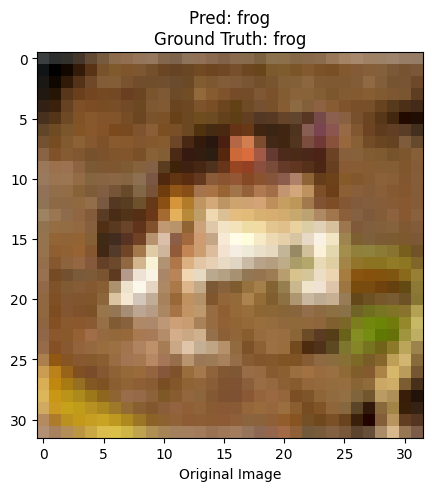

In [2]:
classifier = get_cifar10_image_classifier_pt()
preds = classifier.predict(x_train)

f, ax = plt.subplots(1, 1, constrained_layout = False)
ax.set_title(f'Pred: {labels[np.argmax(y_train[0])]}\nGround Truth: {labels[np.argmax(preds[[0]])]}')
ax.imshow(x_train[0].transpose(1,2,0))
ax.set_xlabel('Original Image')
plt.show()

#### Create a number of differently initialized attacks to test
- vary the max_iter values, all others fixed
- vary the eps_step values, all others fixed

In [3]:
n = 20
attacks = []

# create multiple values for max_iter
max_iter = [i+1 for i in list(range(n))]
print('max_iter values:', max_iter)

# create multiple values for eps
eps_steps = [round(float(i/100+0.001), 3) for i in list(range(n))]
print('eps_step values:', eps_steps)

for i, eps_step in enumerate(eps_steps):
    attacks.append(
        ProjectedGradientDescentPyTorch(
            estimator=classifier,
            norm=np.inf,
            eps=0.1,
            eps_step=eps_step,
            max_iter=10,
            targeted=False,
            batch_size=32,
            verbose=False
        )
    )
    attacks.append(
        ProjectedGradientDescentPyTorch(
            estimator=classifier,
            norm=np.inf,
            eps=0.1,
            max_iter=max_iter[i],
            targeted=False,
            batch_size=32,
            verbose=False
        )
    )
    
print('Number of attacks:', len(attacks))
attack_parallel = AutoAttack(estimator=classifier, attacks=attacks, targeted=True, parallel=True)
attack_non_parallel = AutoAttack(estimator=classifier, attacks=attacks, targeted=True)


max_iter values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
eps_step values: [0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081, 0.091, 0.101, 0.111, 0.121, 0.131, 0.141, 0.151, 0.161, 0.171, 0.181, 0.191]
Number of attacks: 40


#### Run the attack
- using non-parallel AutoAttack
- using parallel AutoAttack

In [4]:
# Run ART attack in non-parallel mode
nonparallel_adv = attack_non_parallel.generate(x=x_train, y=y_train)

# Run ART attack in parallel mode
parallel_adv = attack_parallel.generate(x=x_train, y=y_train)

/Users/kieranfraser/git/personal/art/env/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/kieranfraser/git/personal/art/env/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/kieranfraser/git/personal/art/env/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/kieranfraser/git/personal/art/env/lib/python3.9/multiprocessing/resource_tracker.py:229: UserWarning: resource_tracker: '/loky-2595-nh_wgd4i': [Errno 2] No such file or directory
  warnings.warn('resource_tracker: %r: %s' % (

#### Is the attack robust?
If the attack is robust, predictions for each image will be incorrect and therefore the attack is fully robust.

In [5]:
predictions_parallel = np.sum(np.argmax(classifier.predict(parallel_adv), axis=1) == np.argmax(y_train, axis=1)) == 0
predictions_notparallel = np.sum(np.argmax(classifier.predict(nonparallel_adv), axis=1) == np.argmax(y_train, axis=1)) == 0

print(f'Is AutoAttack non-parallel fully robust: {predictions_notparallel}')
print(f'Is AutoAttack parallel fully robust: {predictions_parallel}')

Is AutoAttack non-parallel fully robust: True
Is AutoAttack parallel fully robust: True


#### Visualize the adversarial images and perturbations
- The first column images is the original image. The title shows the ground truth label and the classifier prediction on the original image. Note that as we are passing ground truth labels to the __generate__ method, attacks won't add perturbations to images that are already misclassified. Perturbations are added to images in which the classifier made correct predictions. 

- The second column images are adversarial images generated by AutoAttack in non-parallel mode - these should be identical to ART core (this is a sanity check to ensure changes have not changed core functionality).

- The fourth column images are adversarial images generated by AutoAttack in parallel mode. Note how parallel model achieves lower L2 distance between the original and adversarial image - as all jobs are run in parallel mode, more attacks can be evaluated and successful attacks with lower perturbations added can be selected.

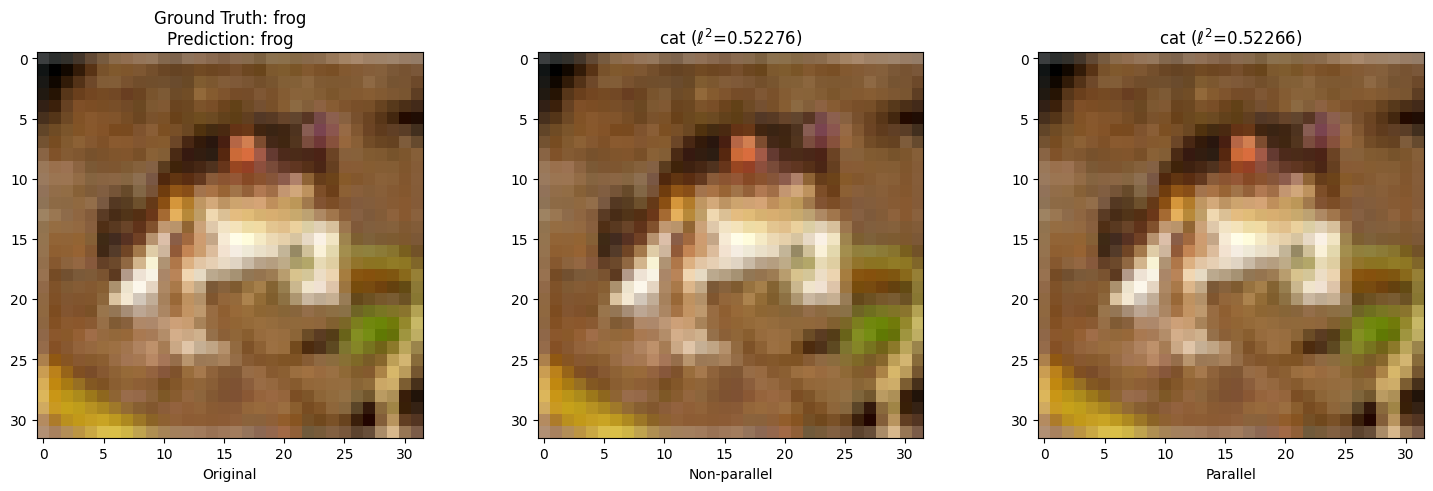

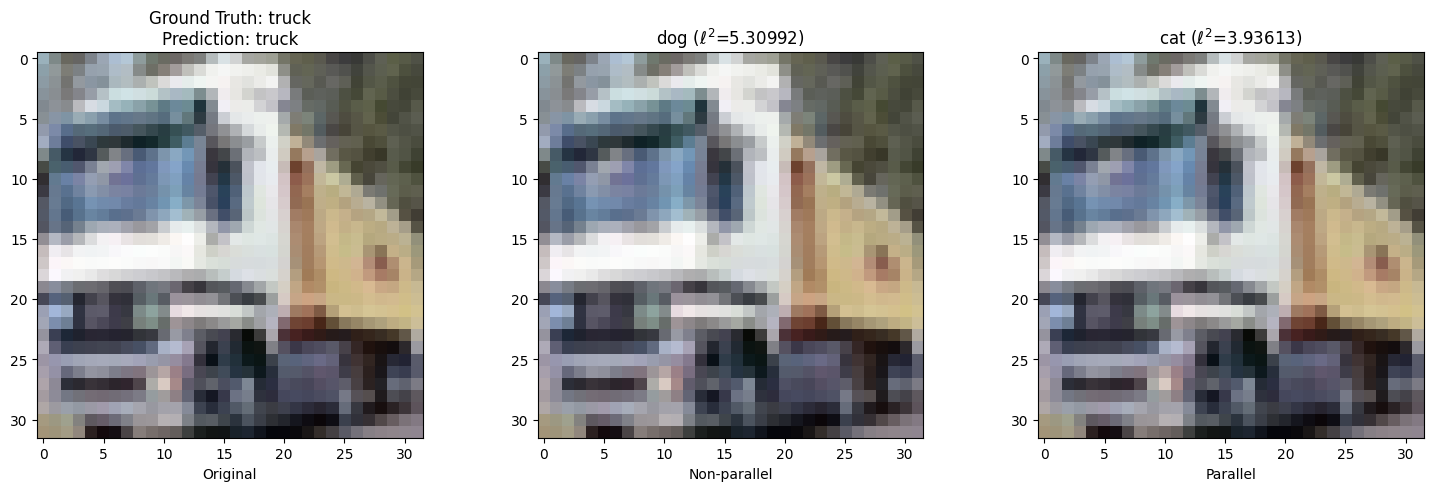

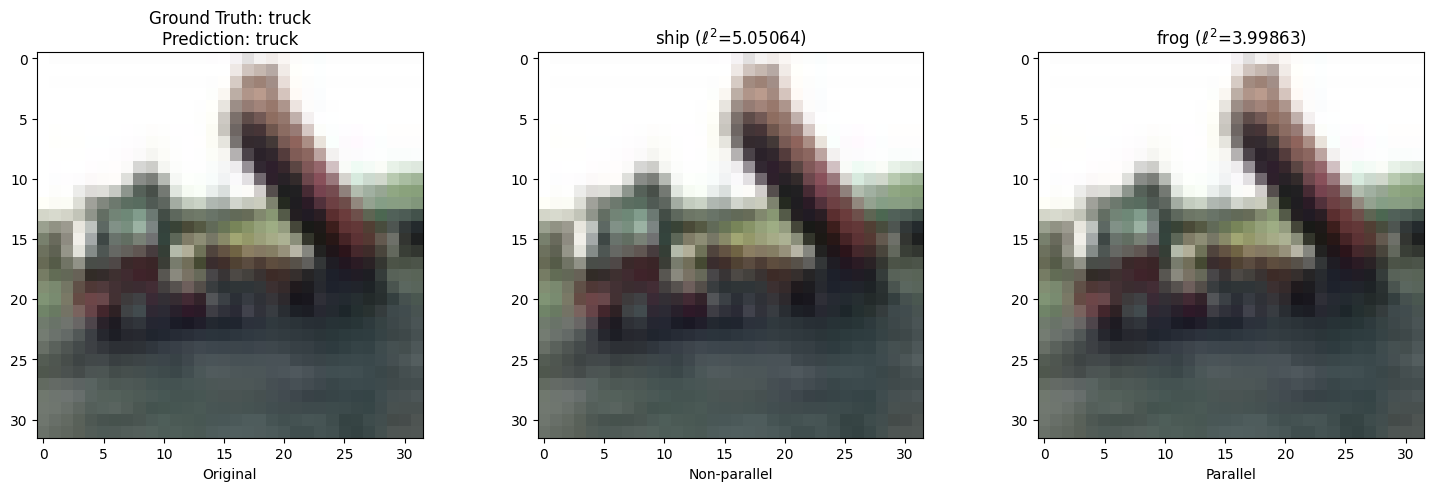

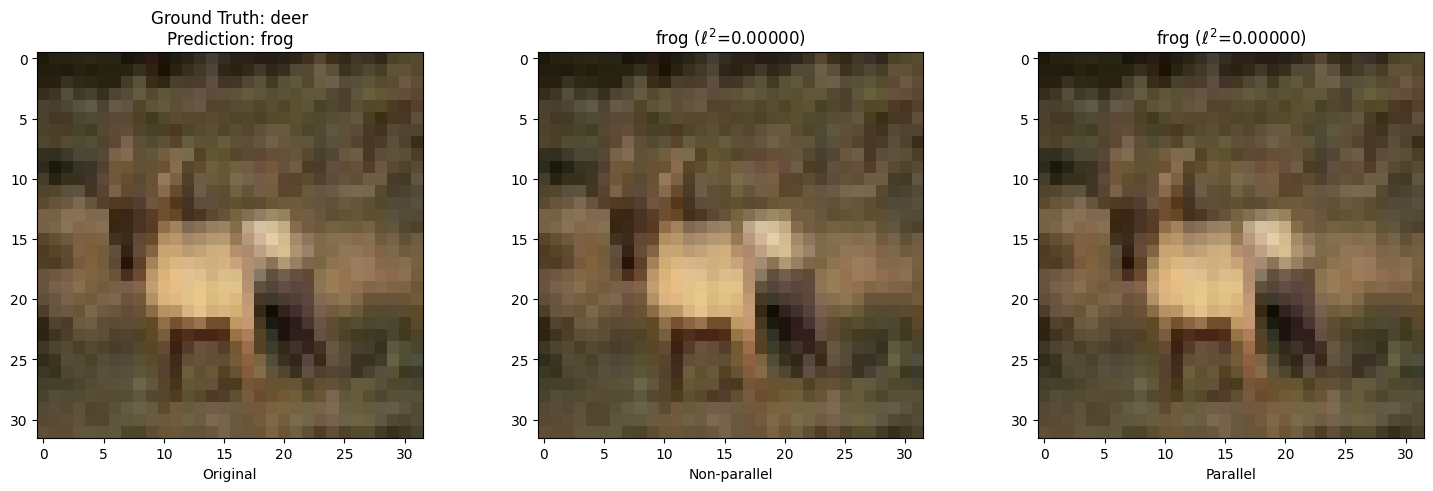

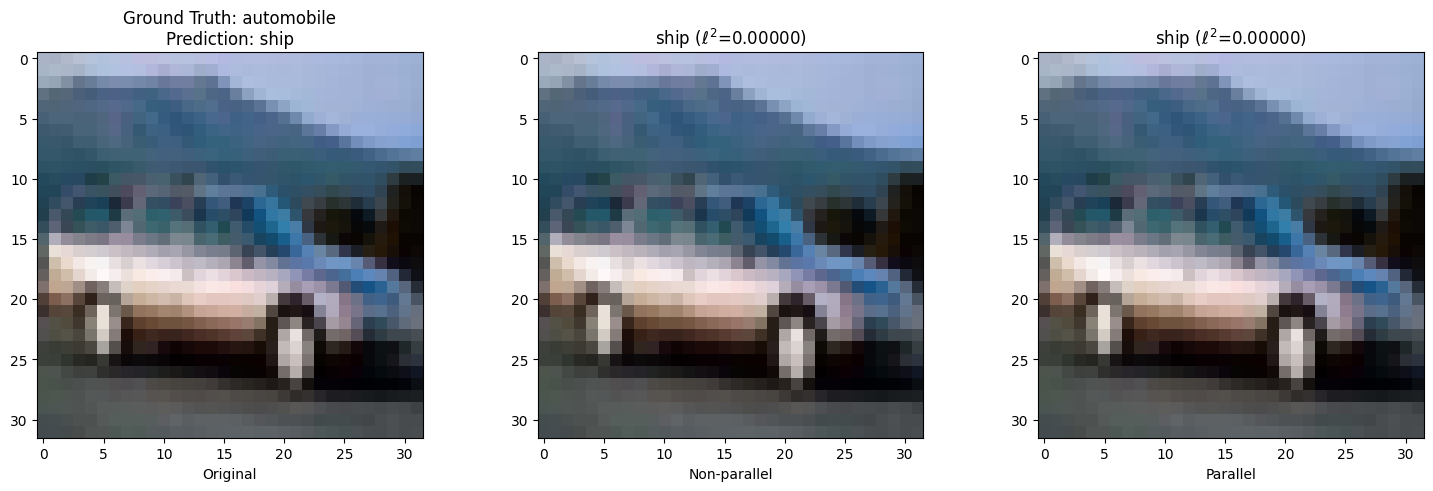

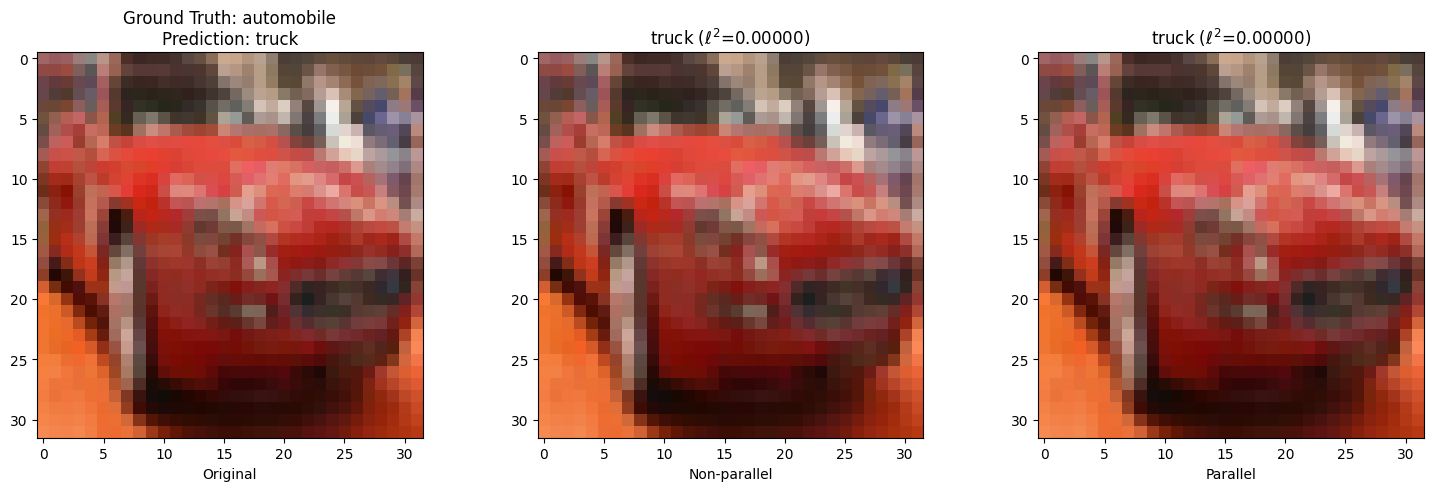

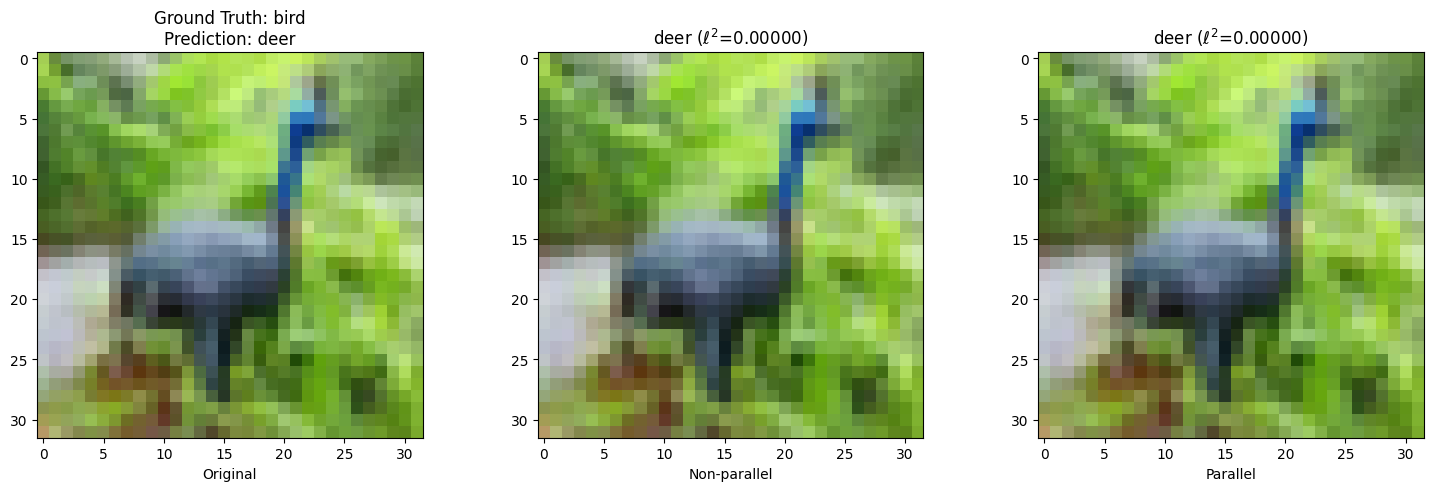

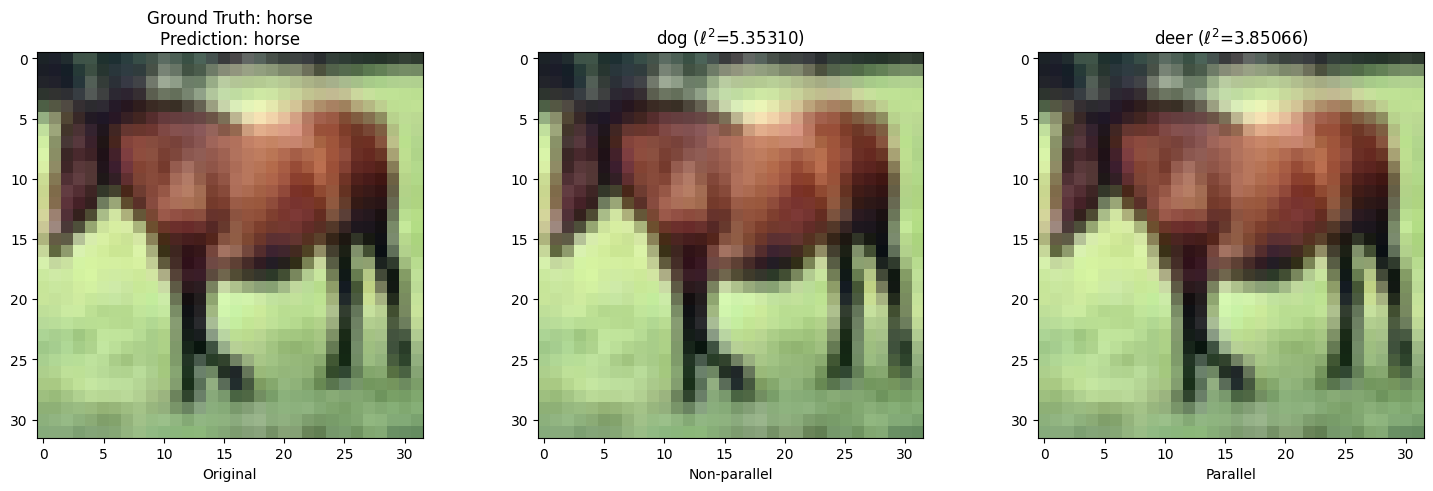

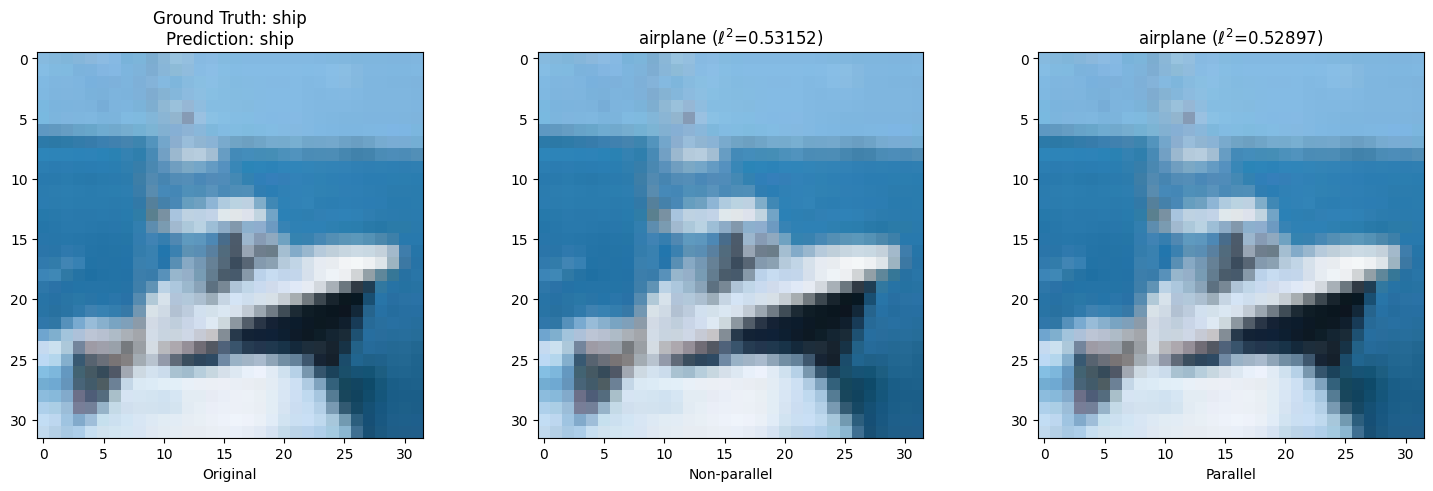

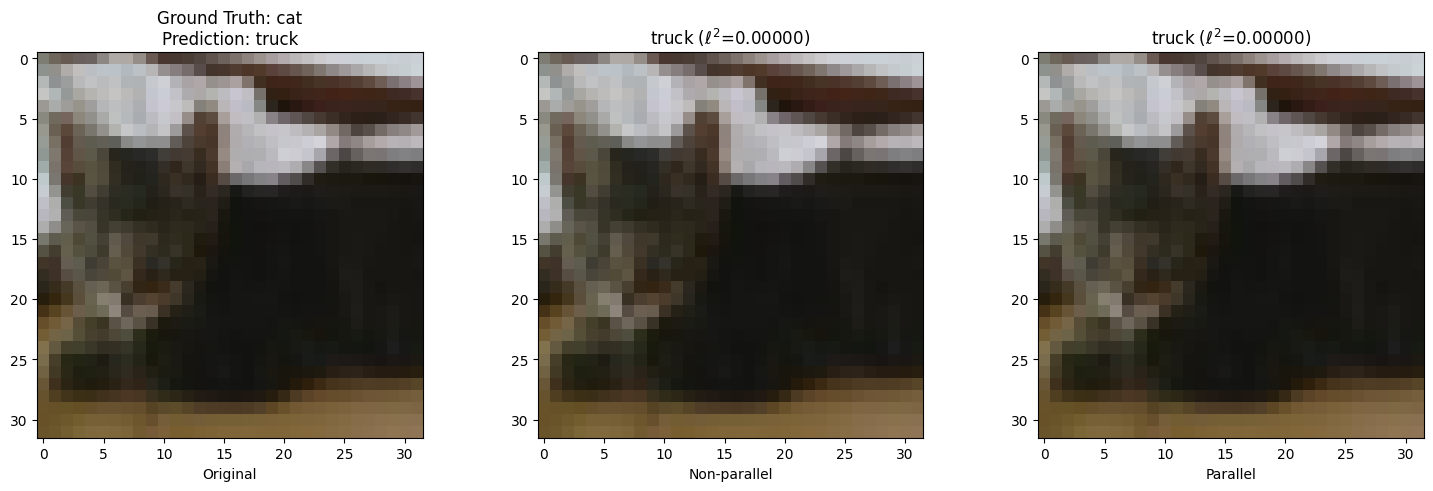

In [6]:
for i in range(len(x_train)):
    f, ax = plt.subplots(1,3, constrained_layout = False)

    nonparallel_perturbation = np.linalg.norm(x_train[[i]] - nonparallel_adv[[i]])
    parallel_perturbation = np.linalg.norm(x_train[[i]] - parallel_adv[[i]])

    ax[0].set_title(f'Ground Truth: {labels[np.argmax(y_train[i])]}\nPrediction: {labels[np.argmax(classifier.predict(x_train[i]))]}')
    ax[0].imshow(x_train[i].transpose(1,2,0))
    ax[0].set_xlabel('Original')

    ax[1].set_title(f'{labels[np.argmax(classifier.predict(nonparallel_adv[i]))]} ($\\ell ^{2}$={nonparallel_perturbation:.5f})')
    ax[1].imshow(x_train[i].transpose(1,2,0))
    ax[1].set_xlabel('Non-parallel')

    ax[2].set_title(f'{labels[np.argmax(classifier.predict(parallel_adv[i]))]} ($\\ell ^{2}$={parallel_perturbation:.5f})')
    ax[2].imshow(x_train[i].transpose(1,2,0))
    ax[2].set_xlabel('Parallel')
    f.set_figwidth(15)
    plt.show()

## Example with MNIST

In [7]:
from tests.utils import get_image_classifier_pt
from art.attacks.evasion.deepfool import DeepFool
from art.attacks.evasion.auto_attack import AutoAttack, AutoProjectedGradientDescent

# Load MNIST data
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist), _, _ = load_dataset('mnist')

x_train_mnist = np.reshape(x_train_mnist, (x_train_mnist.shape[0],) + (1, 28, 28)).astype(np.float32)
x_test_mnist = np.reshape(x_test_mnist, (x_test_mnist.shape[0],) + (1, 28, 28)).astype(np.float32)

n_train = 10
n_test = 10
x_train_mnist = x_train_mnist[:n_train]
y_train_mnist = y_train_mnist[:n_train]
x_test_mnist = x_test_mnist[:n_test]
y_test_mnist = y_test_mnist[:n_test]

classifier = get_image_classifier_pt(from_logits=True)

#### Define attacks to run in parallel 

In [8]:
norm = np.inf
eps = 0.3
eps_step = 0.1
batch_size = 32

attacks = list()
attacks.append(
    AutoProjectedGradientDescent(
        estimator=classifier,
        norm=norm,
        eps=eps,
        eps_step=eps_step,
        max_iter=100,
        targeted=True,
        nb_random_init=5,
        batch_size=batch_size,
        loss_type="cross_entropy",
        verbose=False,
    )
)
attacks.append(
    AutoProjectedGradientDescent(
        estimator=classifier,
        norm=norm,
        eps=eps,
        eps_step=eps_step,
        max_iter=100,
        targeted=False,
        nb_random_init=5,
        batch_size=batch_size,
        loss_type="difference_logits_ratio",
        verbose=False,
    )
)
attacks.append(DeepFool(classifier=classifier, max_iter=100, epsilon=1e-6, nb_grads=3, batch_size=batch_size, verbose=False,))
sa = SquareAttack(estimator=classifier, norm=norm, max_iter=5000, eps=eps, p_init=0.8, nb_restarts=5, verbose=False,)

attacks.append(sa)

attack = AutoAttack(
    estimator=classifier,
    norm=norm,
    eps=eps,
    eps_step=eps_step,
    attacks=attacks,
    batch_size=batch_size,
    estimator_orig=None,
    targeted=True,
    parallel=True,
)

x_train_mnist_adv = attack.generate(x=x_train_mnist, y=y_train_mnist)

/Users/kieranfraser/git/personal/art/env/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '


#### Visualize the performance

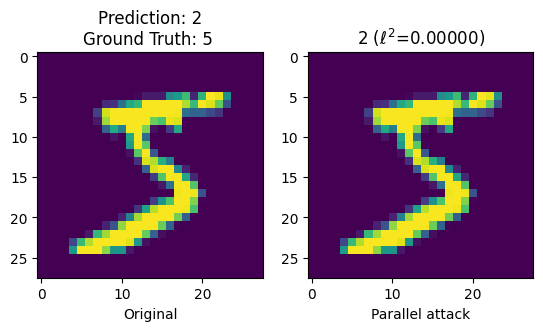

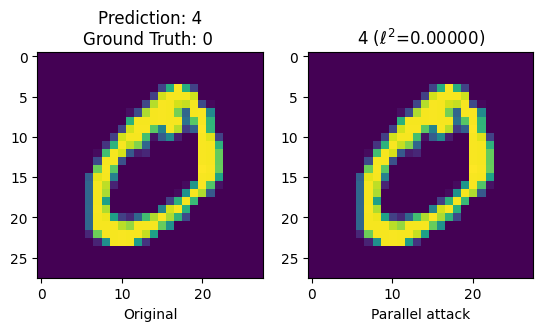

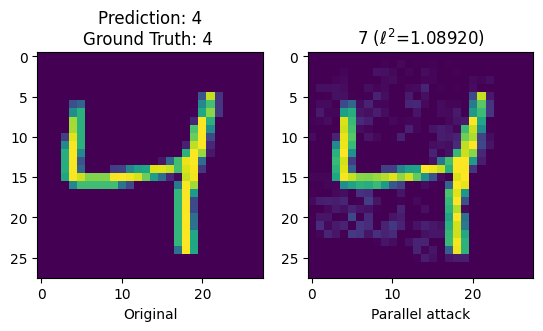

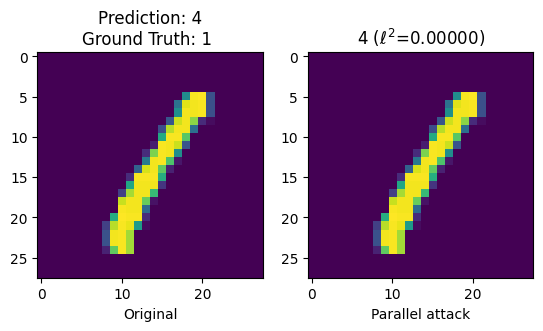

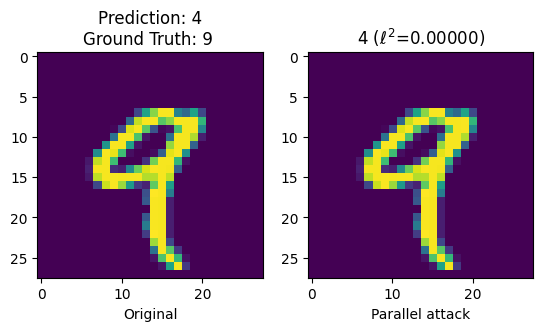

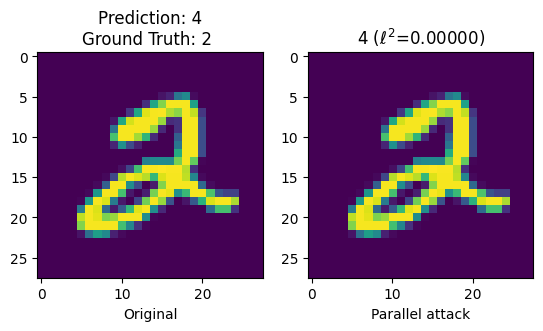

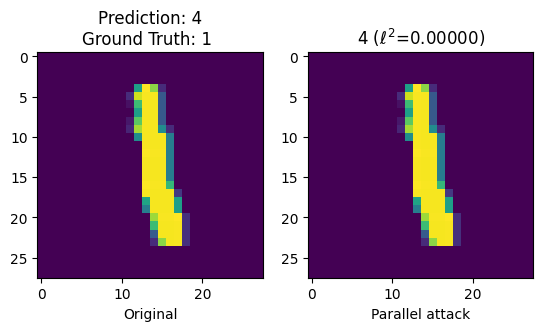

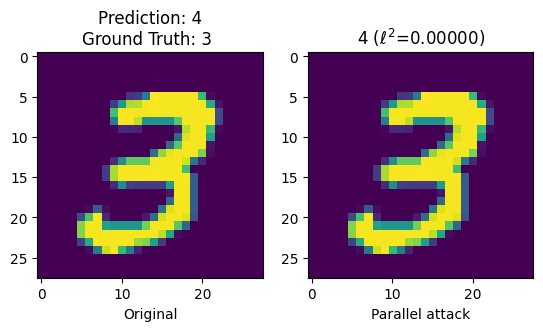

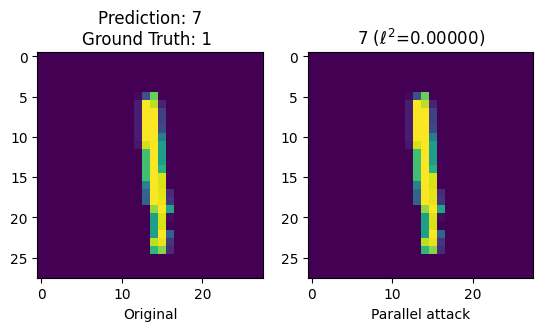

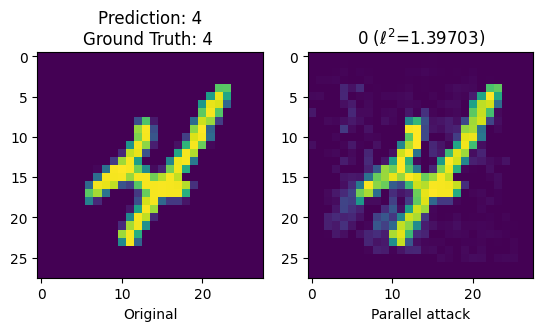

In [26]:
labels = [0,1,2,3,4,5,6,7,8,9]

for i in range(len(x_train_mnist)):
    f, ax = plt.subplots(1,2)

    perturbation = np.linalg.norm(x_train_mnist[[i]] - x_train_mnist_adv[[i]])

    ax[0].set_title(f'Prediction: {labels[np.argmax(classifier.predict(x_train_mnist[i]))]}\nGround Truth: {labels[np.argmax(y_train_mnist[[i]])]} ')
    ax[0].imshow(x_train_mnist[i].transpose(1,2,0))
    ax[0].set_xlabel('Original')

    ax[1].set_title(f'{labels[np.argmax(classifier.predict(x_train_mnist_adv[i]))]} ($\\ell ^{2}$={perturbation:.5f})')
    ax[1].imshow(x_train_mnist_adv[i].transpose(1,2,0))
    ax[1].set_xlabel('Parallel attack')